In [1]:
%pylab inline
%config InlineBackend.figure_format='retina'
from numba import njit

Populating the interactive namespace from numpy and matplotlib


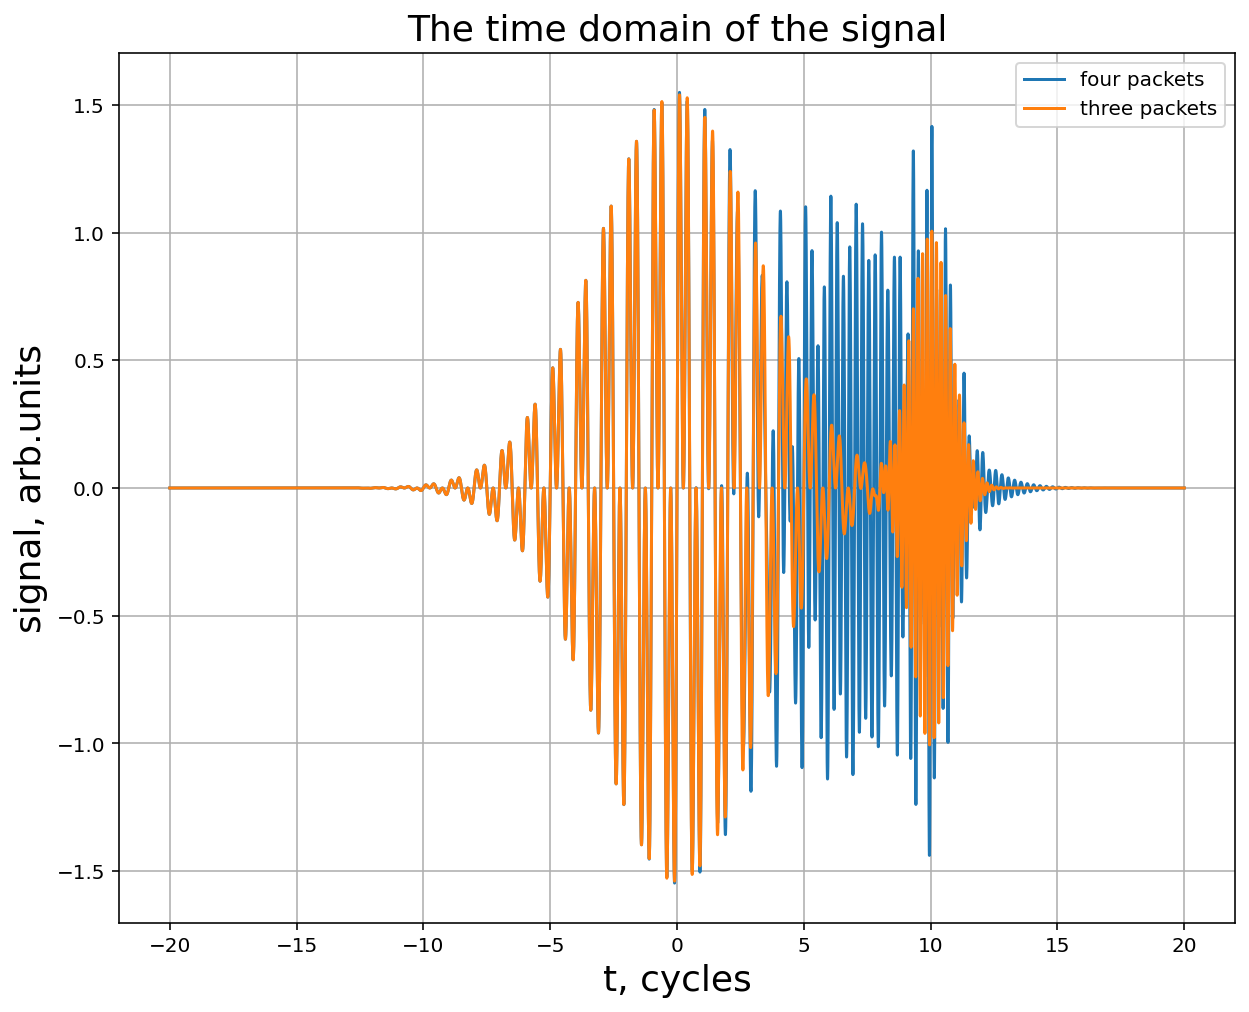

In [2]:
def sine_wave_packet(f=1., t=np.arange(10), t_shift=0., gain=20.):
    """
    F - frequency [Hz]
    t - time [cycles] - time range
    t_shift - time shift relating 0 (<0 - right; >0 - left) [cycles]
    gain - decay rate: less gain - higher decay
    """
    return np.sin(2 * pi * f * t) * exp(-(2 * pi * (t - t_shift)) ** 2 / 2 / gain ** 2)

# generate the time space
t_min = -20
t_max = 20
n_samples = 2**14
t = np.linspace(t_min, t_max, n_samples)

# generate the signal
y = sine_wave_packet(1, t) + sine_wave_packet(3, t) + sine_wave_packet(5.5, t, 10, 5)
y_4 = y + sine_wave_packet(4, t, 7, 15)

plt.figure(figsize=(10, 8))
plt.title('The time domain of the signal', fontsize=18);

plt.plot(t, y_4)
plt.plot(t, y)
plt.legend(["four packets", "three packets"])

xlabel('t, cycles')
ylabel('signal, arb.units')
xlabel('t, cycles', fontsize=18)
ylabel('signal, arb.units', fontsize=18)
plt.grid()
plt.show()

Text(0, 0.5, 'Power spectrum, arb. units')

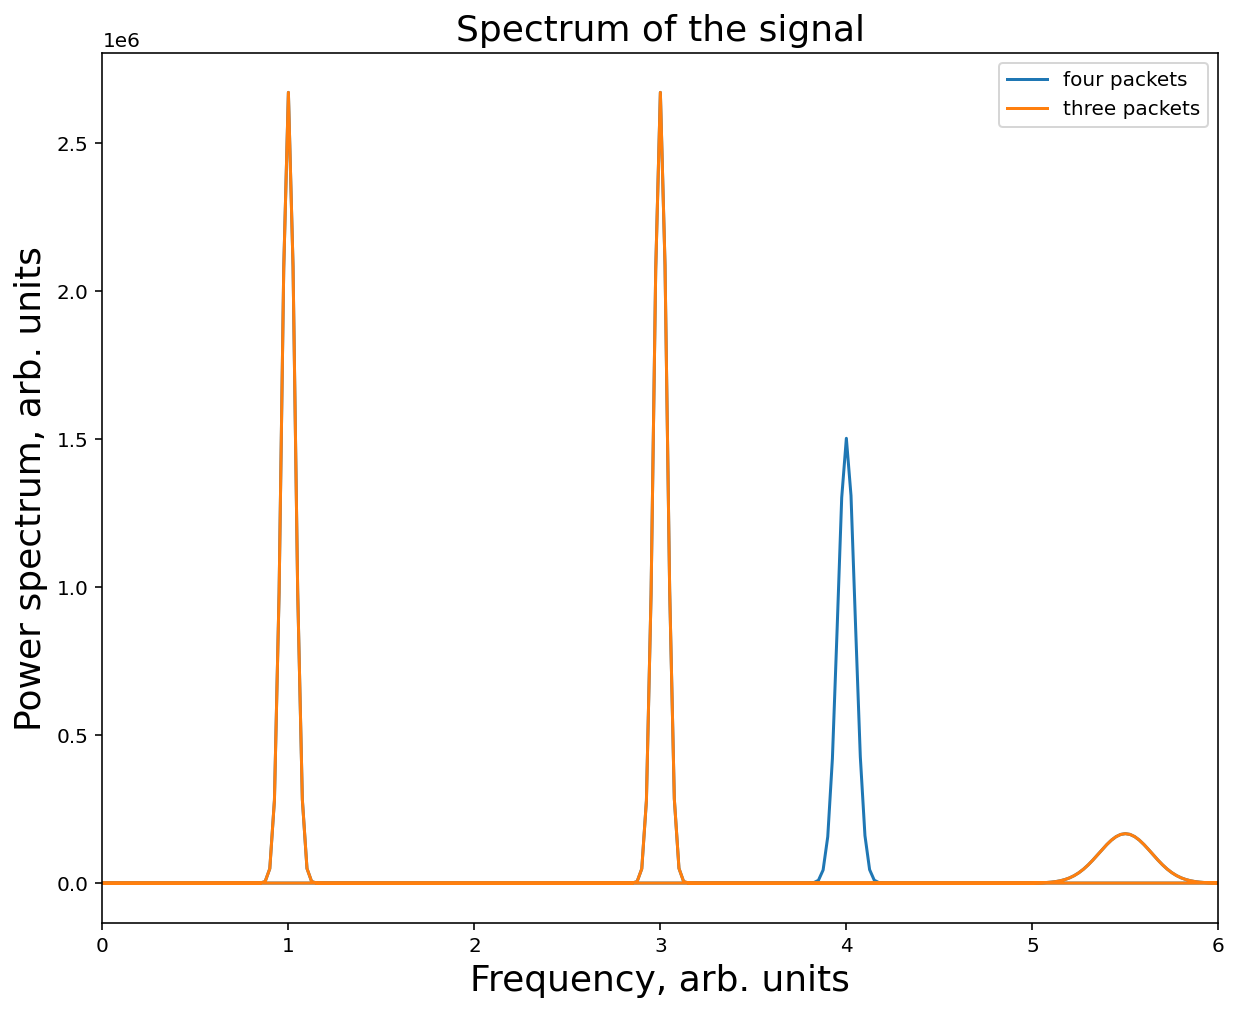

In [3]:
# Fourier spectrum
sp   = np.fft.fft(y)
sp_4 = np.fft.fft(y_4)
w=fft.fftfreq(len(y), d=(t[1]-t[0]))

figure(figsize=(10, 8))
title('Spectrum of the signal', fontsize=18);

plot(w, abs(sp_4)**2)
plot(w, abs(sp)**2)

xlim(0, 6)

legend(["four packets", "three packets"])
xlabel('Frequency, arb. units', fontsize=18)
ylabel('Power spectrum, arb. units', fontsize=18)

In [4]:
@njit(fastmath=True)
def get_windowed(y = np.arange(10), t = np.arange(10), width = 1.):
    windowed_ys = []
    for pos in t:
        window_function = exp(-(2 * pi * (t - pos))**2 / 2 / (2 * pi * width) ** 2)
        windowed_ys.append(y * window_function)
    return windowed_ys

def get_specgram(y, t = np.arange(10), width = 1.):
    windowed = np.array(get_windowed(y, t, width))
    spect = []
    for i in range(windowed.shape[0]):
        y_window = windowed[i]
        spectrum = fft.fft(y_window) # get spectrum
        spect.append(abs(spectrum[0:int(spectrum.shape[0] / 2 - 1)])**2) # get one half of the spectrum
    spectrogram = np.array(spect)
    return spectrogram

In [5]:
n_samples = 2**9
t = np.linspace(t_min, t_max, n_samples)

y = sine_wave_packet(1, t) + sine_wave_packet(3, t) + sine_wave_packet(5.5, t, 10, 5)
y_4 = y + sine_wave_packet(4, t, 7, 15)

In [6]:
spec = get_specgram(y, t, 2)
spec_4 = get_specgram(y_4, t, 2)

Text(0, 0.5, 'Frequency, arb. units')

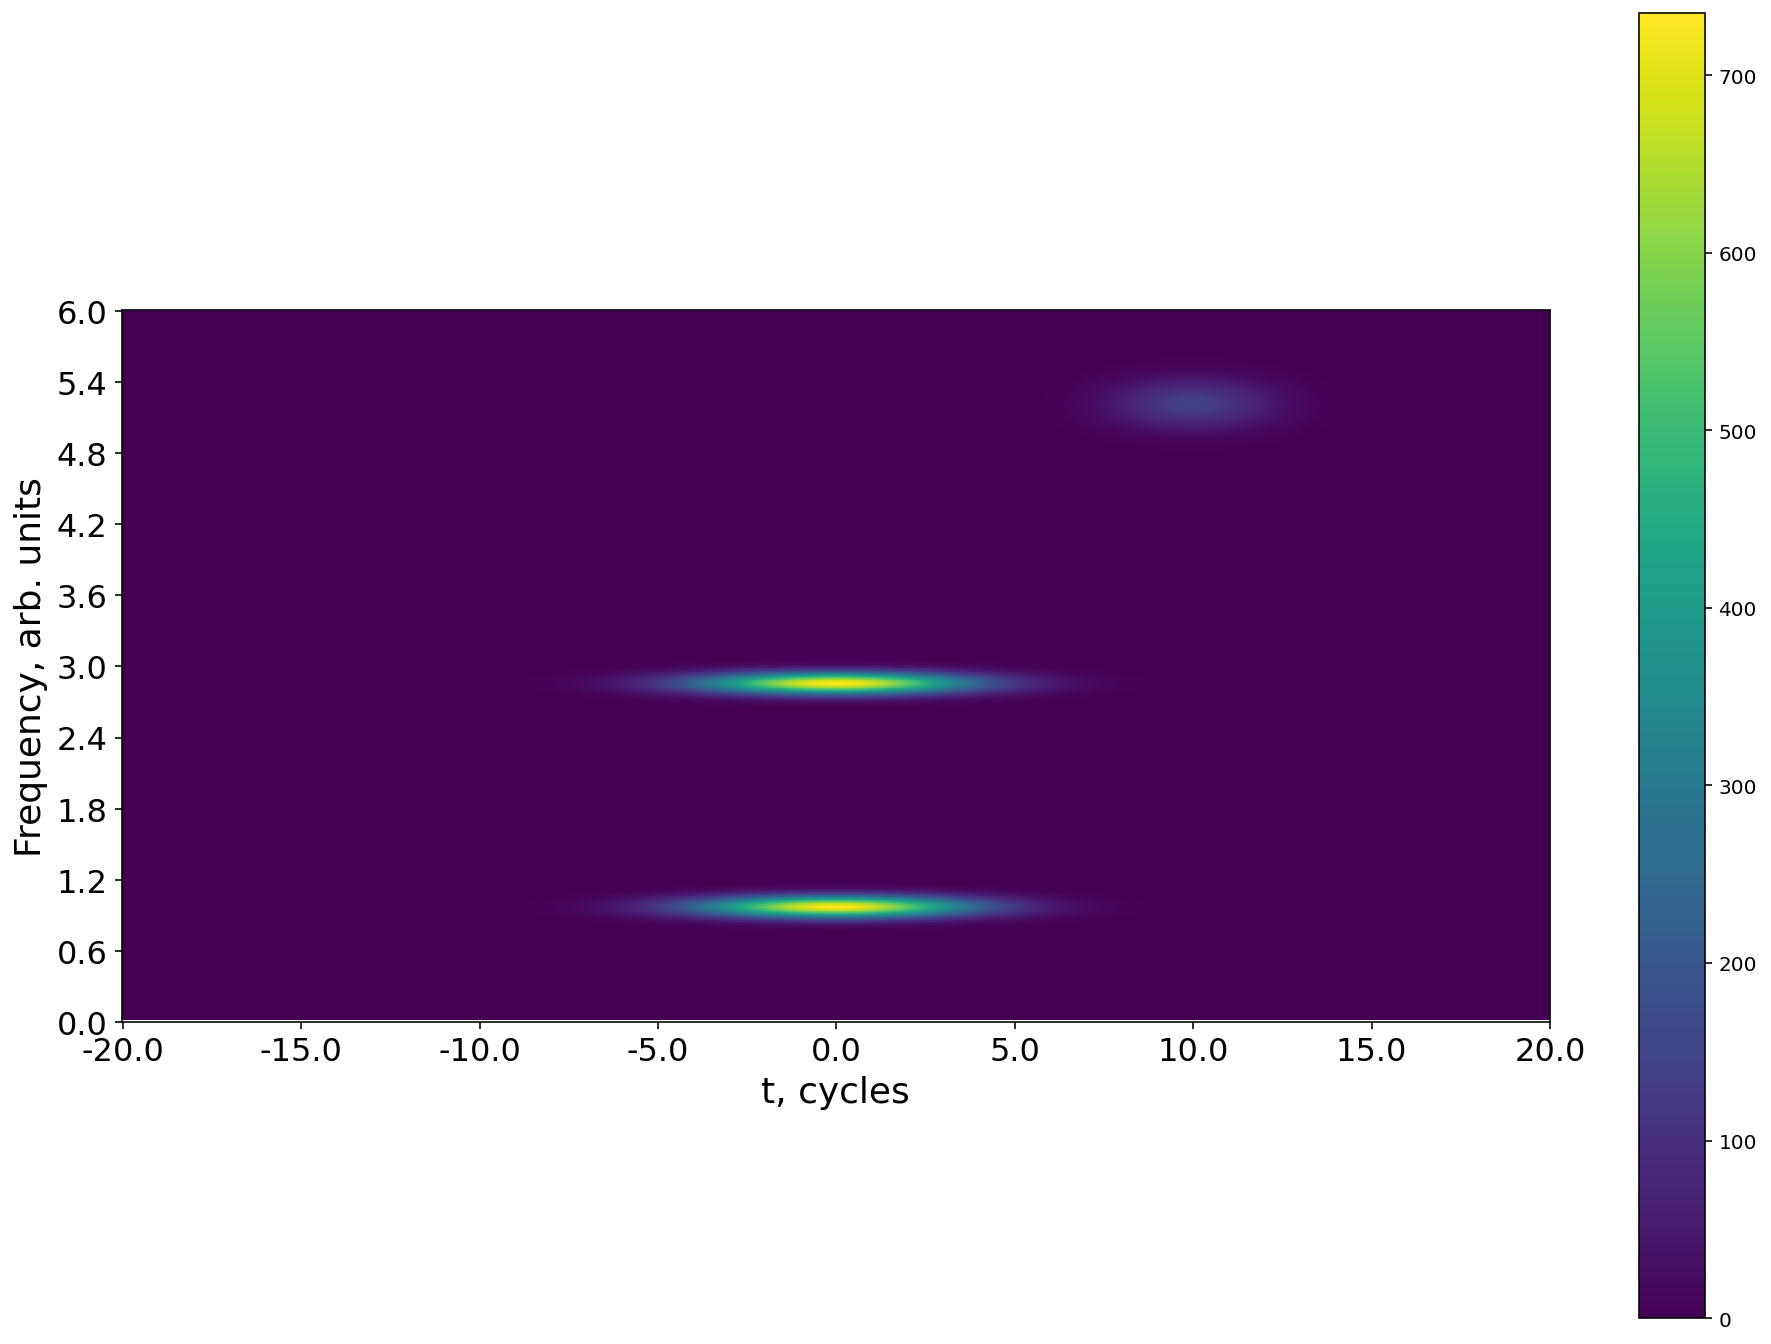

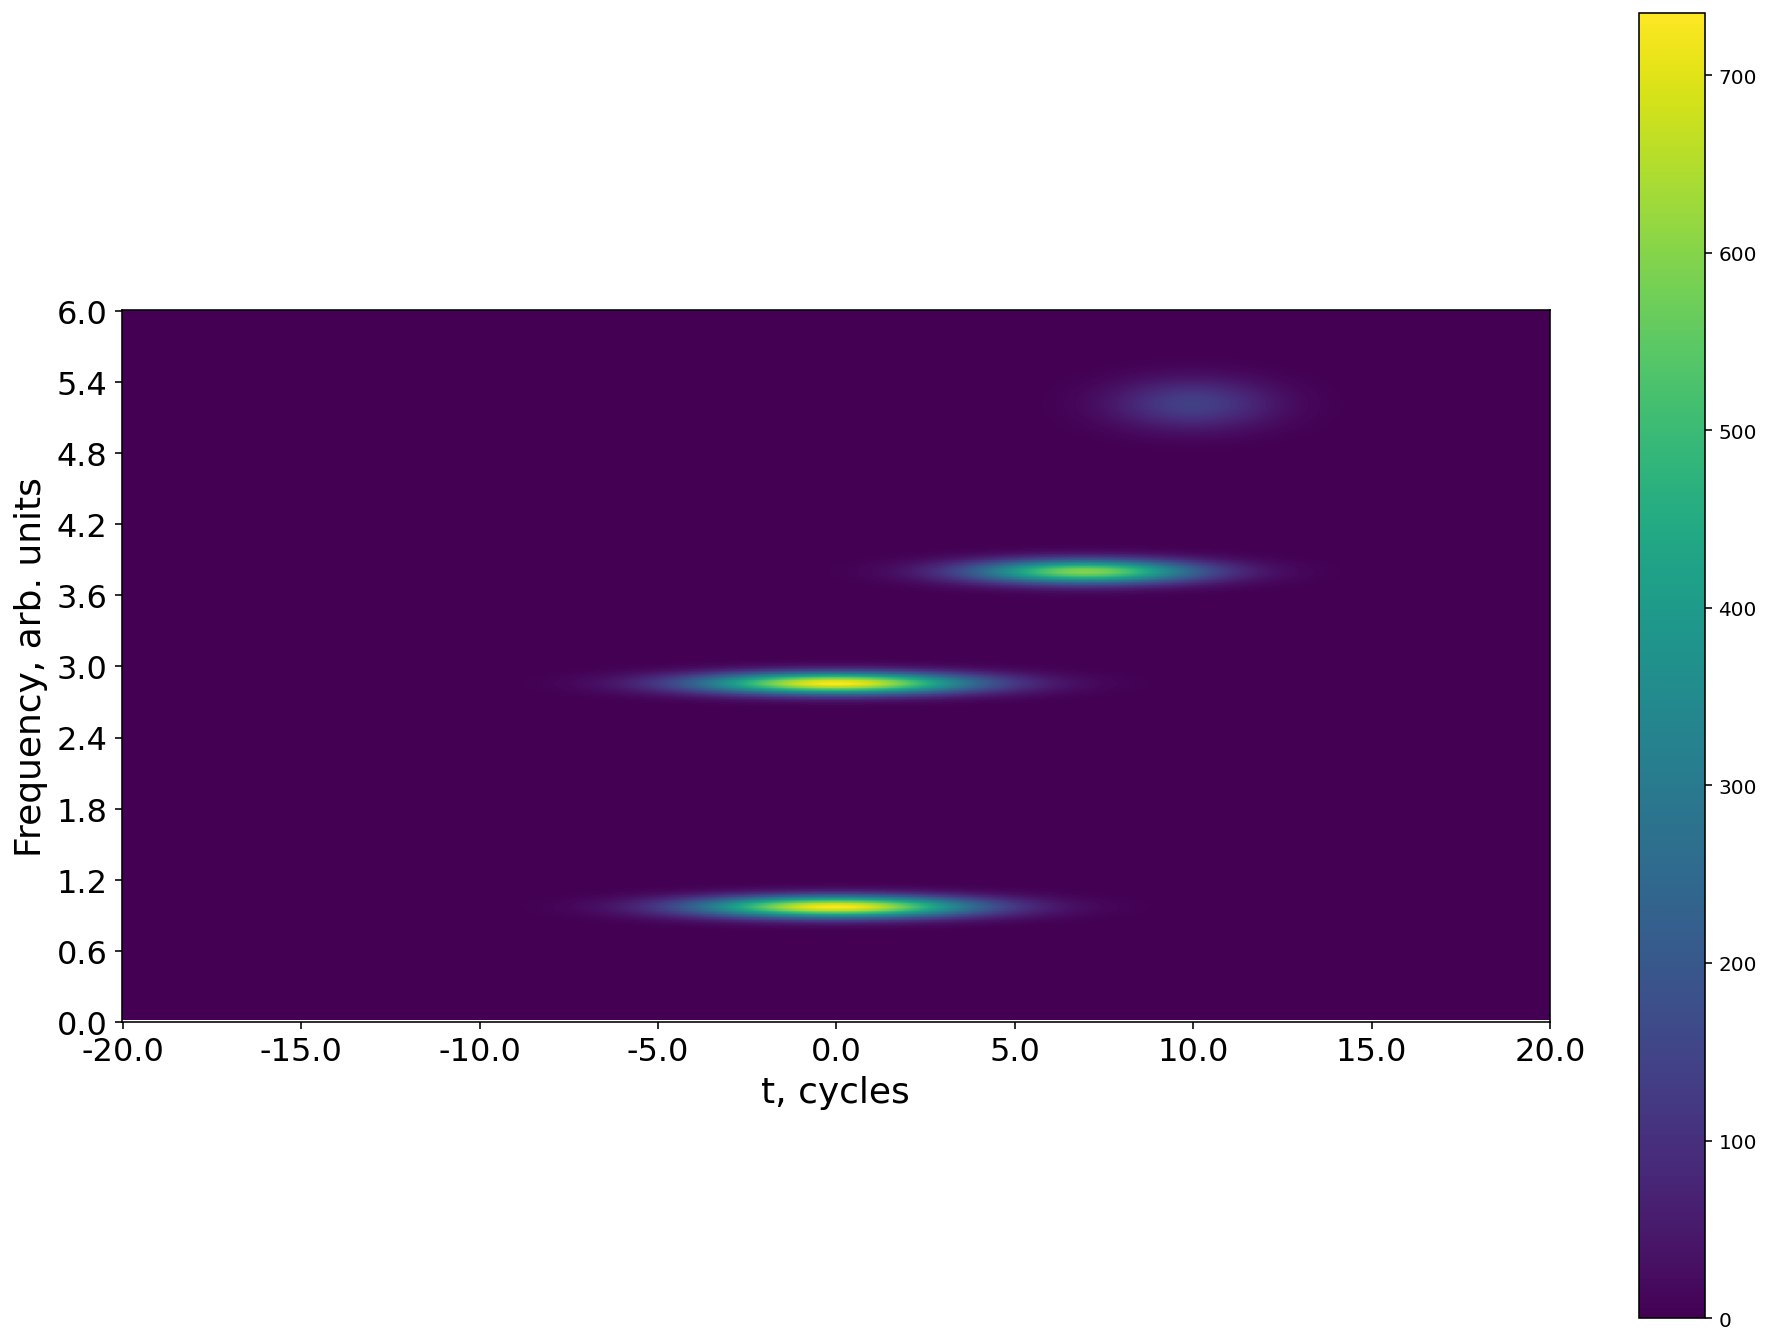

In [7]:
figure(figsize=(16, 12))
imshow(np.rot90(spec)) # choose intager sampling step for image
colorbar()
xticks(np.linspace(0, n_samples, 9), np.round(np.linspace(t_min, t_max, 9), 2), fontsize=16)
yticks(np.linspace(0, n_samples / 2 - 1, 11), np.round(np.linspace(6, 0, 11), 2), fontsize=16) # 1024/80 - scale
xlabel('t, cycles', fontsize=18)
ylabel('Frequency, arb. units', fontsize=18)


figure(figsize=(16, 12))
imshow(np.rot90(spec_4)) # choose intager sampling step for image
colorbar()
xticks(np.linspace(0, n_samples, 9), np.round(np.linspace(t_min, t_max, 9), 2), fontsize=16)
yticks(np.linspace(0, n_samples / 2 - 1, 11), np.round(np.linspace(6, 0, 11), 2), fontsize=16) # 1024/80 - scale
xlabel('t, cycles', fontsize=18)
ylabel('Frequency, arb. units', fontsize=18)

In [8]:
n_samples = 2**11
t = np.linspace(t_min, t_max, n_samples)

y = sine_wave_packet(1, t) + sine_wave_packet(3, t) + sine_wave_packet(5.5, t, 10, 5)

In [9]:
%%timeit
spec = get_specgram(y, t, 2)

120 ms ± 1.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
n_samples = 2**11 + 5
t = np.linspace(t_min, t_max, n_samples)

y = sine_wave_packet(1, t) + sine_wave_packet(3, t) + sine_wave_packet(5.5, t, 10, 5)

In [11]:
%%timeit
spec = get_specgram(y, t, 2)

393 ms ± 10.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
n_samples = 2**11 + 5
t = np.linspace(t_min, t_max, n_samples)

y = sine_wave_packet(1, t) + sine_wave_packet(3, t) + sine_wave_packet(5.5, t, 10, 5)

In [13]:
%%timeit
spec = get_specgram(y, t, 2)

393 ms ± 13.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


This happens due to divide-and-conquer nature of Cooley-tuckey FFT algorithm: although it performs in $O(N \log N)$, we need $N=2^k$ because we recursively reduce our task to two $N/2$-dimensional tasks, them - to four $N/4$-dimensional tasks and so on.